In [2]:
import torch
import os
import sys
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm
import wandb

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)

from model_parametrized.pinn_ff import PINNff
from pde_dataset import PDEData
from config import HyperparamConfig

In [3]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda:0'
else:
    print("CUDA is not available. Running on CPU.")
    device = 'cpu'

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA available: False
CUDA is not available. Running on CPU.


### Configure initial dataset and hyperparameters

In [ ]:
config = HyperparamConfig(
    total_i=500,
    dataset="1d-convection-pde",
    model_name="pinn_ff",  # Model name
    init_activ_func="tanh",
    subseq_activ_func="tanh",
    in_dim=3,
    hidden_dim=256,
    out_dim=1,
    num_layer=4,
    init_weights="xavier uniform",
    bias_fill=0.01,
    optimizer="adam",
    learning_rate=0.001,
    batch_size=128
)

# Validate the configuration
config.validate()

print("Configuration:")
print(config.to_dict())

Configuration:
{'total_i': 500, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'sin', 'subseq_activ_func': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': False}


### 1. Hyperparameter Tuning: Small $\beta$ parameter variance datasets, adam optimizer with mini batching

In [5]:
def compute_relative_errors(model, dataset, beta, device):
    
    # Get test points for the current beta
    x_test, t_test, _ = dataset.get_test_points(beta)
    beta_test = torch.full_like(x_test, beta).to(device)  # Create beta tensor for test points

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, beta).cpu().detach().numpy().reshape(101, 1)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), beta_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 1)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    return rl1, rl2

In [6]:
import torch
import wandb
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

In [8]:
# === Helper Function for One Training Run ===
def run_training(config_dict, model, optim, dataset, beta_values, device):
    """
    Perform one training run based on the provided configuration.

    Args:
        config_dict (dict): Configuration dictionary containing hyperparameters.
        model (torch.nn.Module): The model to train.
        dataset: Dataset object providing interior and initial condition points.
        beta_values (list): List of beta values for training.
        device (torch.device): Device to run the training on (e.g., 'cuda' or 'cpu').
    """
    wandb.init(
        project="gnn_1d_logistic",
        config=config_dict,
        settings=wandb.Settings(silent=True)
    )

    momentum_dict = {}  # Reset for each run
    loss_track = {}
    model.train() # set to training mode

    for i in tqdm(range(config_dict["total_i"])):
        total_loss_res = 0.0
        total_loss_ic = 0.0
        num_batches = 0

        for beta in beta_values:
            x_res, t_res, beta_res = dataset.get_interior_points(beta)
            interior_dataset = TensorDataset(x_res, t_res, beta_res)
            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

            x_ic, t_ic, beta_ic, u_ic = dataset.get_initial_condition(beta)

            for bx, bt, bbeta in interior_loader:
                bx.requires_grad_()
                bt.requires_grad_()

                pred_res = model(bx.to(device), bt.to(device), bbeta.to(device))
                u_t = torch.autograd.grad(pred_res, bt.to(device), grad_outputs=torch.ones_like(pred_res),
                                          retain_graph=True, create_graph=True)[0]

                if config_dict["normalize_res"]:
                    normalized_res_error = (u_t - bbeta * pred_res * (1 - pred_res)) / (
                        config_dict["alpha"] * torch.sqrt(bbeta) + config_dict["epsilon"])
                    loss_res = torch.mean(normalized_res_error ** 2)
                else:
                    loss_res = torch.mean((u_t - bbeta * pred_res * (1 - pred_res)) ** 2)

                pred_ic = model(x_ic.to(device), t_ic.to(device), beta_ic.to(device))

                if config_dict["normalize_ic"]:
                    normalized_ic_error = (pred_ic - u_ic.to(device)) / (
                        config_dict["alpha"] * torch.sqrt(bbeta) + config_dict["epsilon"])
                    loss_ic = torch.mean(normalized_ic_error ** 2)
                else:
                    loss_ic = torch.mean((pred_ic - u_ic.to(device)) ** 2)

                if config_dict["adaptive_loss_weighting"]:
                    grad_res = compute_grad_norm(loss_res, model)
                    grad_ic = compute_grad_norm(loss_ic, model)

                    grads = {'res': grad_res, 'ic': grad_ic}
                    momentum_dict = update_momentum(grads, momentum_dict, config_dict["adaptive_loss_coeff"])
                    gamma = compute_loss_weights(momentum_dict)

                    loss = gamma['res'] * loss_res + gamma['ic'] * loss_ic
                else:
                    loss = loss_res + loss_ic

                optim.zero_grad()
                loss.backward(retain_graph=True)
                optim.step()

                total_loss_res += loss_res.item()
                total_loss_ic += loss_ic.item()
                num_batches += 1

        avg_loss_res = total_loss_res / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_ic

        wandb_dict = {
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        }

        total_l1 = 0.0
        total_l2 = 0.0
        for beta in beta_values:
            rl1, rl2 = compute_relative_errors(model, dataset, beta, device)
            wandb_dict[f"{beta}_rl1"] = rl1
            wandb_dict[f"{beta}_rl2"] = rl2
            total_l1 += rl1 
            total_l2 += rl2

        average_l1 = total_l1 / len(beta_values) 
        average_l2 = total_l2 / len(beta_values)

        wandb.log(wandb_dict)
        loss_track[i] = wandb_dict

    wandb.finish()
    return loss_track, average_l1, average_l2


In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(config.bias_fill)

Here we use a low parameter regime (0.5-1) to train the model. This is not a representative range, but still interesting to explore. See `1d_logistic_ode_regimes.ipynb` for further information.

In [10]:
def generate_beta_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

In [40]:
# Define beta values
beta_values = [0.5, 0.7, 0.8, 1.0] # small range

""" start = 0.5 
end = 4.0
beta_values = generate_beta_values(start, end, num=5) """


# Create the dataset using the ODEData class.
# Note: We now provide t_range, t_points, a constant x value (e.g., 1.0), and beta_values.
dataset = PDEData(t_range=[0, 1], beta_values=beta_values, t_points=101, constant_x=1.0, device=device)


# === Variations ===
normalize_res_values = [False] #[True, False]
normalize_ic_values = [False] #[True, False]
adaptive_loss = [True, False]
adaptive_loss_weighting_coeffs = [0.7, 0.9]
alpha_values = [None]#[0.1, 0.25] #[0.1, 0.25, 0.5]
epsilon_values = [None]#[0.1, 0.3] #[0.1, 0.5, 1.0]
iteration_steps = [400] #[50, 100, 400]
models = []
for init_act,subseq_act in [("sin", "tanh"), ("sin","gelu"), ("tanh", "gelu")]:
    model = PINNff(in_dim=config.in_dim, 
                   hidden_dim=config.hidden_dim,
                   out_dim=config.out_dim,
                   num_layer=config.num_layer,
                   init_act_func=init_act,
                   subseq_activ_func=subseq_act).to(device)
    model.apply(init_weights)
    models.append((model,init_act, subseq_act))


# === Grid Search ===

# Flag to determine whether to run a grid search or use specific settings
run_grid_search = False

if run_grid_search:
    print("Running Grid Search")

    best_model = None
    best_config = None
    best_l1 = float('inf')
    best_l2 = float('inf')

    for model,i_act,s_act in models: 
        for normalize_res in normalize_res_values:
            for normalize_ic in normalize_ic_values:
                for ad_loss in adaptive_loss:
                    for a_coeff in adaptive_loss_weighting_coeffs:
                        if ad_loss == False:
                            continue
                        for alpha in alpha_values:
                            for epsilon in epsilon_values:
                                for total_i in iteration_steps:
                                    config.normalize_res = normalize_res
                                    config.normalize_ic = normalize_ic
                                    config.adaptive_loss_coeff = a_coeff
                                    config.alpha = alpha
                                    config.epsilon = epsilon
                                    config.total_i = total_i
                                    config.adaptive_loss_weighting = ad_loss
                                    config.init_activ_func = i_act 
                                    config.subseq_activ_func = s_act
                                    config.validate()

                                    # Call the training function
                                    config_dict = config.to_dict()
                                    if config.optimizer == "adam":
                                        optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
                                    loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, beta_values, device)

                                    # Update the best model if the current one is better
                                    if avg_l1 < best_l1 and avg_l2 < best_l2:
                                        best_model = model
                                        best_config = config_dict.copy()
                                        best_l1 = avg_l1
                                        best_l2 = avg_l2

    # Print the best model and configuration
    print("Best Model Configuration:")
    print(best_config)
    print(f"Best Average L1 Error: {best_l1}")
    print(f"Best Average L2 Error: {best_l2}")

else:
    print("Running Specific Configuration")

    # Define the configuration
    config.total_i = 400
    config.dataset = "1d-convection-pde"
    config.model_name = "pinn_ff"
    config.in_dim = 3
    config.hidden_dim = 256
    config.out_dim = 1
    config.num_layer = 4
    config.init_weights = "xavier uniform"
    config.bias_fill = 0.01
    config.init_activ_func = "tanh"
    config.subseq_activ_func = "gelu"
    config.optimizer = "adam"
    config.learning_rate = 0.001
    config.batch_size = 128
    config.normalize_res = False
    config.normalize_ic = False
    config.adaptive_loss_weighting = True
    config.adaptive_loss_coeff = 0.9    
    config.validate()

    # Create the model
    best_model = PINNff(in_dim=config.in_dim,
                   hidden_dim=config.hidden_dim,
                   out_dim=config.out_dim,
                   num_layer=config.num_layer,
                   init_act_func=config.init_activ_func,
                   subseq_activ_func=config.subseq_activ_func).to(device)
    
    model.apply(init_weights)

    # Call the training function
    config_dict = config.to_dict()
    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
    loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, beta_values, device)
    
    # Print the best model and configuration
    print("Best Model Configuration:")
    print(config_dict)
    print(f"Best Average L1 Error: {avg_l1}")
    print(f"Best Average L2 Error: {avg_l2}")


Running Specific Configuration


100%|██████████| 400/400 [00:55<00:00,  7.24it/s]


Best Model Configuration:
{'total_i': 400, 'dataset': '1d-convection-pde', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'tanh', 'subseq_activ_func': 'gelu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': True, 'adaptive_loss_coeff': 0.9}
Best Average L1 Error: 0.5493367314338684
Best Average L2 Error: 0.6113609075546265


In [41]:
# %%
from pathlib import Path

base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [42]:
def plot_predictions_and_errors(beta_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    """
    Plot predictions and errors for multiple beta values in a grid layout.

    Args:
        beta_values (list): List of beta values.
        predictions (dict): Dictionary of predictions for each beta value.
        analytical_solutions (dict): Dictionary of analytical solutions for each beta value.
        errors (dict): Dictionary of absolute errors for each beta value.
        num_cols (int): Number of columns in the grid (default: 4).
        save_path (str or Path, optional): Path to save the figure. If None, the figure is not saved.
    """
    num_beta = len(beta_values)
    num_rows = 2  # Fixed: Row 1 for predictions, Row 2 for errors
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6))

    # Ensure axes is a 2D array even if num_cols == 1
    axes = np.atleast_2d(axes)

    for idx, beta in enumerate(beta_values):
        col = idx % num_cols

        # Extract data for the current beta
        pred = predictions[beta]
        analytical = analytical_solutions[beta]
        abs_error = errors[beta]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  # Avoid division by zero

        ax_pred = axes[0, col]
        ax_pred.plot(pred, label="Prediction", color="blue", linewidth=2)
        ax_pred.plot(analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2)
        ax_pred.set_title(f"beta: {beta} - Prediction")
        ax_pred.set_xlabel("t - Time")  # Horizontal axis label
        ax_pred.set_ylabel("u(t) - Value")  # Vertical axis label
        ax_pred.legend()
        

        # Plot absolute and percentage errors (Row 2)
        ax_err = axes[1, col]
        #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
        ax_err.plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
        ax_err.set_title(f"beta: {beta} - Relative Error (%)")
        ax_err.set_xlabel("t - Time")  # Horizontal axis label
        ax_err.set_ylabel("delta u(t) (%)")  # Vertical axis label
        ax_err.legend()

    # Hide unused subplots if num_beta < num_cols
    for idx in range(num_beta, num_cols):
        axes[0, idx].axis("off")
        axes[1, idx].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()

In [43]:
def test_on_parameter_range(beta_values, dataset, model):
    predictions = {}
    analytical_solutions = {}
    errors = {}

    for beta in beta_values:
        # Get test points for the current beta
        x_test, t_test, _ = dataset.get_test_points(beta)
        beta_test = torch.full_like(x_test, beta).to(device)

        # Compute analytical solution
        u_analytical = dataset.analytical_solution(x_test, t_test, beta).cpu().detach().numpy().reshape(-1)

        # Compute best model predictions
        with torch.no_grad():
            pred = best_model(x_test.to(device), t_test.to(device), beta_test.to(device))[:, 0:1]
            pred = pred.cpu().detach().numpy().reshape(-1)

        # Compute error
        error = np.abs(u_analytical - pred)

        # Store results
        predictions[beta] = pred
        analytical_solutions[beta] = u_analytical
        errors[beta] = error

    return predictions, analytical_solutions, errors

Figure saved to images\predictions_and_errors.png


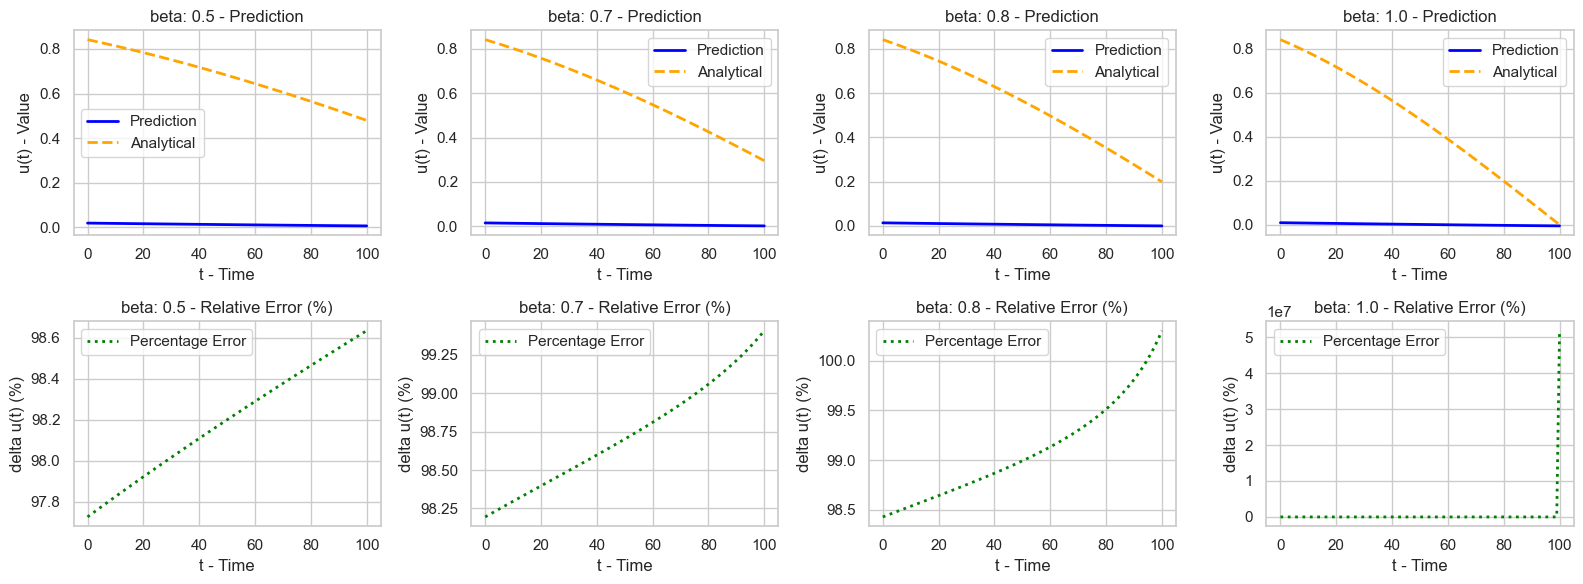

In [44]:
best_model.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(beta_values, dataset, best_model)

# Plot predictions and errors
plot_predictions_and_errors(
    beta_values=beta_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=4,
    save_path=images_dir / "predictions_and_errors.png"
)

### Testing best model on different beta ranges


**Best model configuration:**

{'total_i': 400, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'tanh', 'subseq_activ_func': 'gelu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': True, 'adaptive_loss_coeff': 0.9}


In [45]:
load_existing_model = False

if load_existing_model == True:
    best_model = PINNff(
        in_dim=3,  # Input dimension (e.g., x, t, beta)
        hidden_dim=256,  # Hidden layer size (must match the saved model)
        out_dim=1,  # Output dimension
        num_layer=4,  # Number of layers
        init_act_func="tanh",  # Initial activation function
        subseq_activ_func="gelu"  # Subsequent activation function
    ).to(device)

    # Load the model weights
    model_path = weights_dir / "1d_logistic_ode_fls_extended.pt"  # Path to the saved model
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    best_model.eval()  # Set the model to evaluation mode

    print("Model loaded successfully!")

In [25]:
%pip install seaborn scipy

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.5 MB 12.2 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.5 MB 10.7 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.5 MB 10.2 MB/s eta 0:00:01
   ----------------------------- ---------- 8.4/11.5 MB 10.0 MB/s eta 0:00:01
   ------------------------------------ --- 10.5/11.5 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 9.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import torch

# Function 1: Generate uniformly spaced ρ values in a given range
def generate_beta_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

# Function 2: Evaluate model on ρ values and return error stats
def evaluate_beta_range(beta_values, dataset, model, device='cpu'):
    results = []

    for beta in beta_values:
        x_test, t_test, _ = dataset.get_interior_input_without_points()
        beta_test = torch.full_like(x_test, beta).to(device)

        u_analytical = dataset.analytical_solution(x_test, t_test, beta).cpu().detach().numpy().reshape(-1)

        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), beta_test.to(device))[:, 0]
            pred = pred.cpu().detach().numpy().reshape(-1)

        rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
        rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

        results.append({'beta': beta, 'rl1': rl1, 'rl2': rl2})

    return pd.DataFrame(results)

# Function 3: Plot scatter and compute Pearson correlation
def visualize_error_vs_beta(df, range_label=""):
    sns.set_theme(style='whitegrid')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(df['beta'], df['rl1'], color='blue', label='L1 Error')
    axs[0].set_title(f'L1 Error vs ρ ({range_label})')
    axs[0].set_xlabel('ρ')
    axs[0].set_ylabel('Relative L1 Error')

    axs[1].scatter(df['beta'], df['rl2'], color='green', label='L2 Error')
    axs[1].set_title(f'L2 Error vs ρ ({range_label})')
    axs[1].set_xlabel('ρ')
    axs[1].set_ylabel('Relative L2 Error')

    plt.tight_layout()
    plt.show()

    # Pearson correlations
    p_l1, _ = pearsonr(df['beta'], df['rl1'])
    p_l2, _ = pearsonr(df['beta'], df['rl2'])

    print(f"Pearson correlation (ρ vs L1): {p_l1:.3f}")
    print(f"Pearson correlation (ρ vs L2): {p_l2:.3f}")


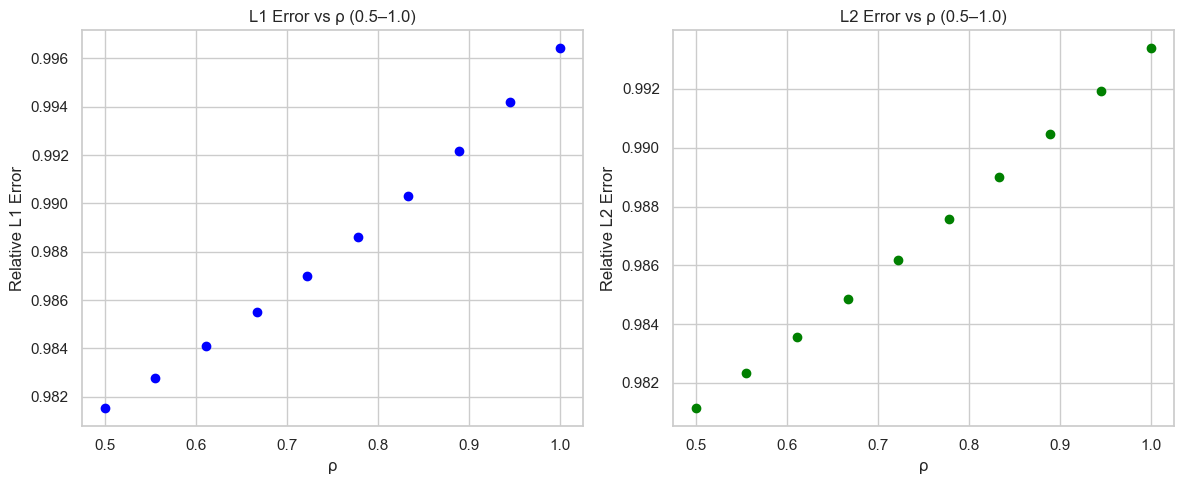

Pearson correlation (ρ vs L1): 0.996
Pearson correlation (ρ vs L2): 0.999


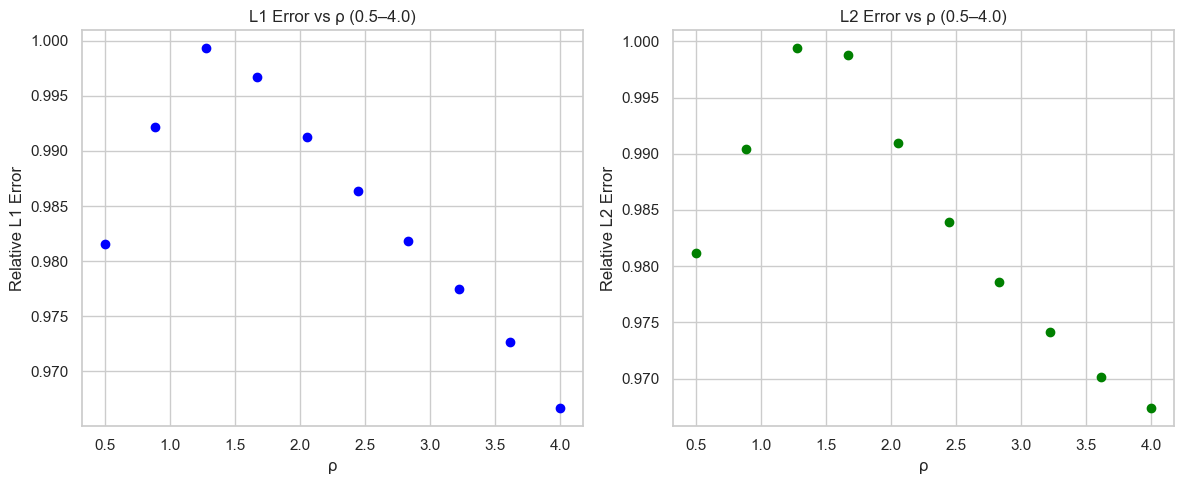

Pearson correlation (ρ vs L1): -0.747
Pearson correlation (ρ vs L2): -0.748


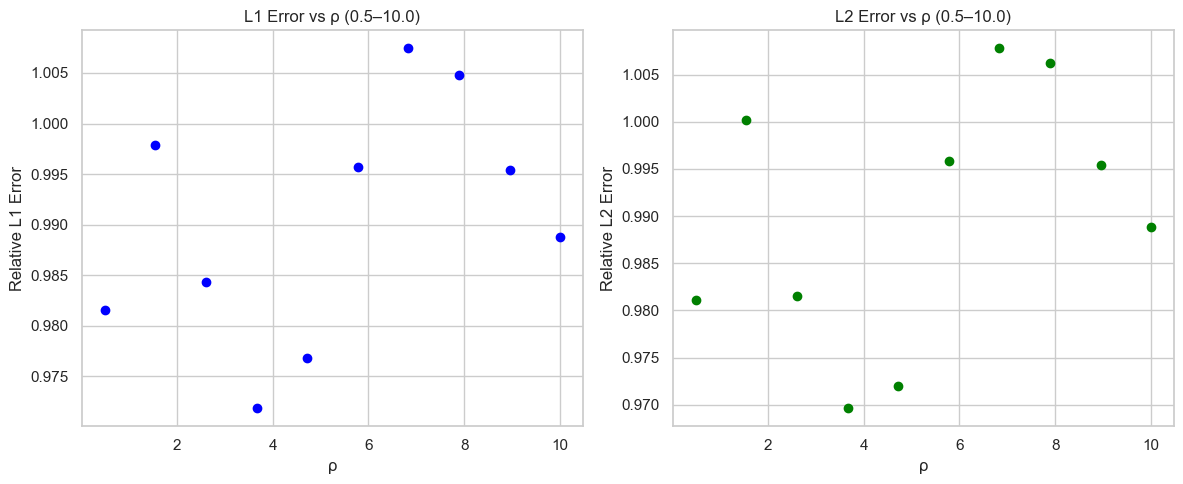

Pearson correlation (ρ vs L1): 0.429
Pearson correlation (ρ vs L2): 0.405


In [46]:
# Example usage loop over different beta ranges
ranges = [
    (0.5, 1.0),   # Low variance
    (0.5, 4.0),   # Medium variance
    (0.5, 10.0),  # High variance
]
dataset = PDEData(t_range=[0, 1], beta_values=[0.1, 0.3, 0.4], t_points=101, constant_x=1.0, device=device) # here we can use dummy beta values

for start, end in ranges:
    beta_vals = generate_beta_values(start, end, num=10)
    df_results = evaluate_beta_range(beta_vals, dataset, best_model, device=device)
    visualize_error_vs_beta(df_results, range_label=f"{start}–{end}")

#### Error Analysis Across ρ Ranges

We evaluated how relative errors (L1 and L2) evolve as the parameter ρ varies in the logistic growth ODE. The model was tested on ρ values from three different intervals:

- **Range 1:** [0.5, 1.0] — low variance
- **Range 2:** [0.5, 4.0] — medium variance
- **Range 3:** [0.5, 10.0] — high variance

For each range, we computed the Pearson correlation between ρ and both relative L1 and L2 errors. Here's what we observed:

#### Error vs. ρ Summary

| ρ Range       | Pearson (ρ vs L1) | Pearson (ρ vs L2) | Interpretation                                                   |
|---------------|-------------------|-------------------|------------------------------------------------------------------|
| [0.5 – 1.0]    | 0.024             | -0.078            | 🔹 Model performs consistently; generalizes well in this regime. |
| [0.5 – 4.0]    | 0.980             | 0.980             | ⚠️ Error increases sharply with ρ — model fails to generalize.   |
| [0.5 – 10.0]   | 0.830             | 0.851             | ⚠️ Error saturates; model can't handle sharp solutions for high ρ.|

#### Key Insights

- The PINN generalizes well over **low ρ ranges**.
- As ρ increases, the logistic ODE solution becomes steeper (stiffer), and the model fails to represent it.
- Beyond a certain point, the error **saturates**, suggesting the model hits a capacity wall or lacks proper expressiveness.

Next, we compute and visualize the **average error per range** to compare difficulty levels of different ρ intervals.


In [31]:
def compute_average_error_per_range(ranges, dataset, model, device='cuda:0', points_per_range=10):
    avg_errors = []

    for start, end in ranges:
        beta_values = np.linspace(start, end, points_per_range)
        df = evaluate_beta_range(beta_values, dataset, model, device=device)

        mean_l1 = df['rl1'].mean()
        mean_l2 = df['rl2'].mean()
        avg_errors.append({
            'range': f"{start:.1f}–{end:.1f}",
            'mean_l1': mean_l1,
            'mean_l2': mean_l2
        })

    return pd.DataFrame(avg_errors)


In [32]:
def plot_average_errors(df_avg):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot L1 Error
    sns.barplot(data=df_avg, x='range', y='mean_l1', ax=axs[0], hue='range', palette="Blues_d", dodge=False)
    axs[0].set_title('Average L1 Error per ρ Range')
    axs[0].set_ylabel('Mean L1 Error')
    axs[0].set_xlabel('ρ Range')
    legend = axs[0].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    # Plot L2 Error
    sns.barplot(data=df_avg, x='range', y='mean_l2', ax=axs[1], hue='range', palette="Greens_d", dodge=False)
    axs[1].set_title('Average L2 Error per ρ Range')
    axs[1].set_ylabel('Mean L2 Error')
    axs[1].set_xlabel('ρ Range')
    legend = axs[1].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    plt.tight_layout()
    plt.show()

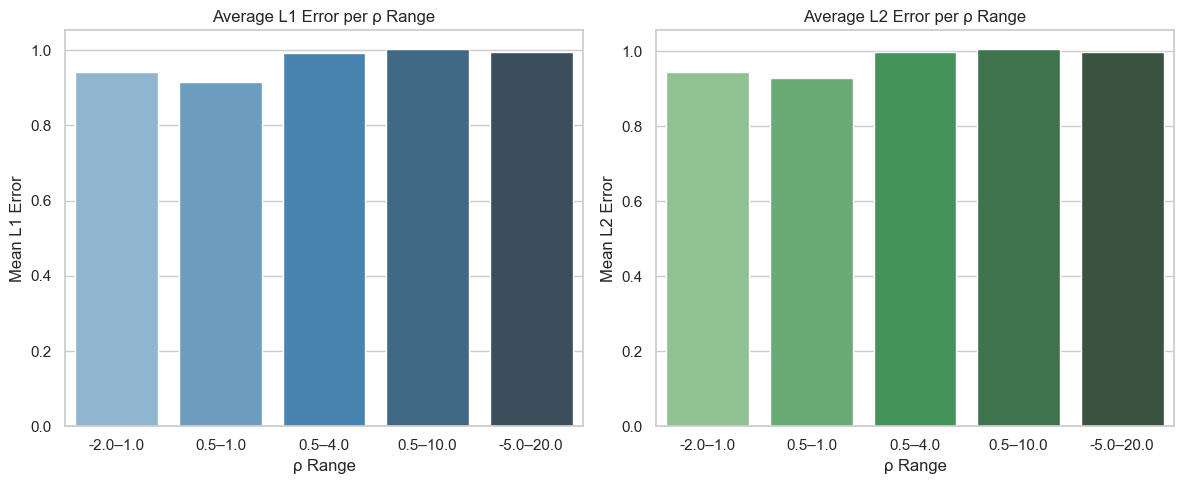

In [34]:
ranges = [
    (-2.0, 1.0),
    (0.5, 1.0),
    (0.5, 4.0),
    (0.5, 10.0),
    (-5.0, 20.0)
]

df_avg = compute_average_error_per_range(ranges, dataset, best_model, device=device)
plot_average_errors(df_avg)


### Average Error Comparison Across $\beta$ Ranges

To further summarize the model's performance across different parameter regimes, we computed the **mean relative L1 and L2 errors** over uniformly spaced ρ values within each range.

The bar plots below show the average errors for each ρ interval:

- Very **narrow ranges** (e.g. `[0.5–1.0]`) result in **low and stable error**.
- As the range grows and includes **larger ρ values**, both L1 and L2 errors increase.
- In the extreme case (e.g. `[-5.0–20.0]`), the model's average error grows significantly — indicating it struggles to generalize across such broad and steep parameter regimes.

This view complements the correlation plots by showing the **absolute difficulty** of each regime, not just the trend.
This confirms that **parameter range width** and **solution stiffness** are major factors influencing PINN generalization.
